In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from yahooquery import Ticker
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [14]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [15]:
s32 = Ticker('S32.AX')

In [16]:
data = s32.history(period='5y').reset_index()
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [17]:
data.dtypes

symbol               object
date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume                int64
adjclose            float64
dividends           float64
dtype: object

In [11]:
data = data.drop(['symbol', 'open', 'high', 'low', 'close', 'volume', 'dividends'], axis=1)


In [19]:
data.adjclose

0       2.818267
1       2.835991
2       2.995516
3       3.022104
4       2.933479
          ...   
1262    4.480000
1263    4.330000
1264    4.290000
1265    4.160000
1266    4.160000
Name: adjclose, Length: 1267, dtype: float64

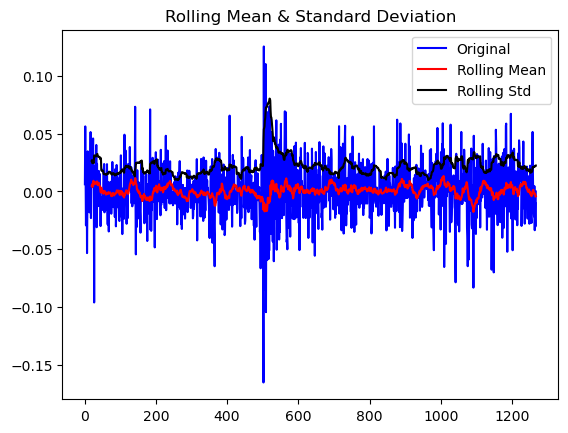

Results of Dickey-Fuller Test:
Test Statistic                  -38.975438
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1265.000000
Critical Value (1%)              -3.435530
Critical Value (5%)              -2.863827
Critical Value (10%)             -2.567988
dtype: float64


In [22]:
test_stationarity(data.adjclose.pct_change().dropna())

In [23]:
df = data.adjclose.apply(np.log)
df

0       1.036122
1       1.042392
2       1.097117
3       1.105953
4       1.076189
          ...   
1262    1.499623
1263    1.465568
1264    1.456287
1265    1.425515
1266    1.425515
Name: adjclose, Length: 1267, dtype: float64

In [68]:
DAYS = 50
n_features = 1

In [38]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [162]:
X, y = preprocess_lstm(np.array(df), 50, n_features)

In [46]:
len(df)*0.15

189.9

In [163]:
split = 0.075
day_split = -int(split*len(df))


X_train, y_train = X[:2*day_split], y[:2*day_split]
X_valid, y_valid = X[2*day_split:day_split], y[2*day_split:day_split]
X_test, y_test = X[day_split:], y[day_split:]

In [165]:
train_original             

,date,adjclose
0,2018-03-12,2.871442
1,2018-03-13,2.818266
2,2018-03-14,2.818266
3,2018-03-15,2.835992
4,2018-03-16,2.995516
...,...,...
1072,2022-06-06,4.926957
1073,2022-06-07,4.975836
1074,2022-06-08,5.054042
1075,2022-06-09,4.897631


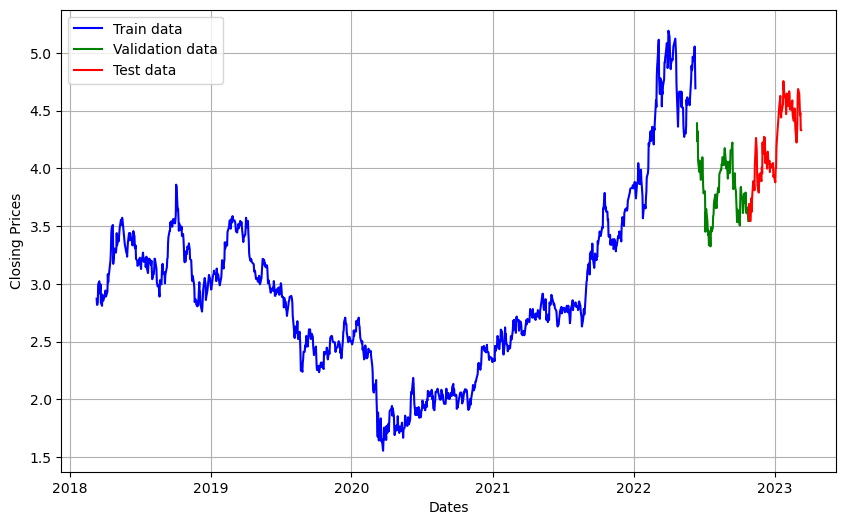

In [164]:
train_original = data.iloc[:2*day_split]
valid_original = data.iloc[2*day_split:day_split]
test_original = data.iloc[day_split:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original.date, train_original.adjclose, 'b', label='Train data')
plt.plot(valid_original.date, valid_original.adjclose, 'g', label='Validation data')
plt.plot(test_original.date, test_original.adjclose, 'r', label='Test data')
plt.legend()

In [101]:
%%capture 
!pip install tensorflow

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [166]:
model = Sequential()

In [167]:
model.add(LSTM(units=100, input_shape=(DAYS, n_features)))
model.add(Dense(1))

In [168]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               40800     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.compile(optimizer='adam', 
              loss='MeanAbsolutePercentageError',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [170]:
model.fit(X_train, y_train, epochs=15, batch_size = 32)

Epoch 1/15
33/33 [==============================] - 4s 28ms/step - loss: 21.8104 - mean_absolute_error: 0.2259
Epoch 2/15
33/33 [==============================] - 1s 30ms/step - loss: 4.6315 - mean_absolute_error: 0.0452
Epoch 3/15
33/33 [==============================] - 1s 29ms/step - loss: 3.9320 - mean_absolute_error: 0.0378
Epoch 4/15
33/33 [==============================] - 1s 29ms/step - loss: 3.7528 - mean_absolute_error: 0.0360
Epoch 5/15
33/33 [==============================] - 1s 28ms/step - loss: 3.5685 - mean_absolute_error: 0.0343
Epoch 6/15
33/33 [==============================] - 1s 29ms/step - loss: 3.4892 - mean_absolute_error: 0.0329
Epoch 7/15
33/33 [==============================] - 1s 29ms/step - loss: 3.1981 - mean_absolute_error: 0.0303
Epoch 8/15
33/33 [==============================] - 1s 27ms/step - loss: 3.0958 - mean_absolute_error: 0.0291
Epoch 9/15
33/33 [==============================] - 1s 30ms/step - loss: 3.0515 - mean_absolute_error: 0.0287
Epoch 10/

In [171]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
3/3 [==============================] - 1s 16ms/step - loss: 2.4631 - mean_absolute_error: 0.0332
Test MSE: 2.4630606174468994
Test MAE: 0.03320147469639778


3/3 [==============================] - 0s 12ms/step


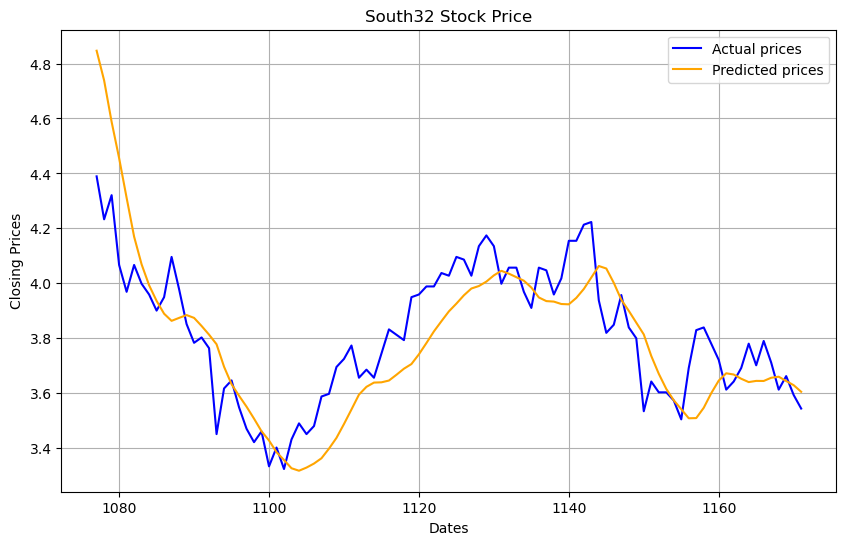

In [172]:
# Prediction
y_pred = model.predict(X_valid)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], valid_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
#pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-2*day_split:] 

# Add trend back in
#pred_data['price'] = pred_data['Close'].add(1,fill_value=0).cumprod() * train_original.adjclose.iloc[-1]
pred_data['price'] = pred_data['Close'].apply(np.exp)

# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(valid_original['adjclose'],'b',label='Actual prices')
plt.plot(pred_data['price'], 'orange',label='Predicted prices')
plt.title('South32' + ' Stock Price')

plt.legend()

In [144]:
pred_data.head(20)

,Close,price
939,0.001220,3.352197
940,0.001214,3.356267
941,0.001318,3.360692
942,0.001320,3.365128
943,0.001233,3.369278
944,0.001333,3.373771
945,0.001230,3.377921
946,0.001248,3.382137
947,0.001112,3.385897
948,0.001304,3.390311


In [89]:
y_pred = model.predict(X_valid)
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])



pred_data

6/6 [==============================] - 0s 9ms/step


,Close,price
1078,-0.008497,3.234544
1079,-0.005370,3.217175
1080,-0.002841,3.208033
1081,-0.001717,3.202525
1082,-0.006967,3.180212
...,...,...
1262,-0.002902,1.817443
1263,-0.004015,1.810146
1264,-0.004960,1.801168
1265,-0.000298,1.800631


In [76]:
df1 = pd.DataFrame({
    'value': [44, 45, 33, 56, 60]
})

df1['pct_change'] = df1['value'].pct_change() # get changes
initial_value=df1['value'].values[0] # store the initial value

In [79]:
df1['value2'] = df1['pct_change'].add(1,fill_value=0).cumprod()*44

In [85]:
train_original

,date,adjclose
0,2018-03-12,2.871442
1,2018-03-13,2.818266
2,2018-03-14,2.818266
3,2018-03-15,2.835992
4,2018-03-16,2.995516
...,...,...
884,2021-09-06,3.169679
885,2021-09-07,3.112909
886,2021-09-08,3.179141
887,2021-09-09,3.081026
